---
author: Chia-Wei Hsu
date: "2025-12-01"
---

# Access JRA3Q through the NCAR GDEX AI Ready Format

:::{important} AI Ready
The "AI ready format" means the data is stored in .zarr or virtualizarr/kerchunk format, with an accompanying intake-ESM catalog that indexes all available datasets hosted on NCAR GDEX. The format is designed to opitmized the data access for any kinds of AI/ML workflow that utilize the object storage.
:::

## Required Packages
Here we will list the required packages to be able to perform the following steps. Please make sure to installed the packages before moving forward
- `intake`
- `intake-esm` 
- `matplotlib`
- `xarray`
- `kerchunk`

:::{important} intake-esm package
Currently, we use a pinned version since there are two main bugs in the currently version
```bash
pip install intake-esm @ git+https://github.com/chiaweh2/intake-esm.git@3f6645cb959336e4b7dfd2843f2c6706dfe70646
```
1. Error when lazy loading of some CSV files 
2. Missing kerchunk engine in xarray to load the reference file
:::

## Step 1 - know what you want
In this example, we will show how to find the needed variables in the JRA3Q data. Let's start by assuming we need to find the surface temperature in the dataset. For the analysis, we will plot a spatial map of surface temperature and calculate the global mean surface temperature over the entire period of the dataset.

## Step 2 - Locate the Catalog
On the NCAR GDEX portal, go to the `Data Access` tab for your selected dataset. Scroll down to find a purple row labeled `Catalog` with an `Analysis ready` tag. Click on the Web File List to view the available catalog files in `.json` format. Use the copy Full URL button to obtain the direct link to the catalog file, which you can use in your analysis workflow.

:::{figure}
:label: GDEX-portal-jra3q
:align: center

(dataaccess)=
![Click on Data Acess Button](../doc/images/jra3q_dataacess_top.png)

![Scroll to bottom to find the Catalog of AI Ready and click on the web file listing](../doc/images/jra3q_dataacess_bottom.png)

![Pick one refence file URL that suits you](../doc/images/jra3q_catalog.png)

Steps to Find the AI Ready Catalog!
:::

In [2]:
# Catalog location for NCAR GDEX AI Ready Format datasets
catalog_url = "https://data.gdex.ucar.edu/d640000/catalogs/d640000-https.json"

## Step 3 - Open the Catalog
This is the steps where the `intake` and `intake-esm` package works their magic to show us all the data that have been cataloged without the need of actually knowing the data/folder structure that is used in the background. 

In [3]:
import intake
import intake_esm
cat = intake.open_esm_datastore(catalog_url)

In [4]:
# take a look at the first 15 rows of the catalog
cat.df.head(5)

,path,variable,format,short_name,long_name,units,start_time,end_time,level,level_units,frequency
0,https://data.gdex.ucar.edu/d640000/kerchunk/an...,bvf2-theta-an-gauss,reference,bvf2-theta-an-gauss,Square of Brunt-Vaisala frequency,s-2,1947-09-01 00:00:00,2025-09-30 18:00:00,air_potential_temperature,K,21600000000000 nanoseconds
1,https://data.gdex.ucar.edu/d640000/kerchunk/an...,hgt-theta-an-gauss,reference,hgt-theta-an-gauss,Geopotential height,gpm,1947-09-01 00:00:00,2025-09-30 18:00:00,air_potential_temperature,K,21600000000000 nanoseconds
2,https://data.gdex.ucar.edu/d640000/kerchunk/an...,mntsf-theta-an-gauss,reference,mntsf-theta-an-gauss,Montgomery stream function,m2 s-2,1947-09-01 00:00:00,2025-09-30 18:00:00,air_potential_temperature,K,21600000000000 nanoseconds
3,https://data.gdex.ucar.edu/d640000/kerchunk/an...,original_number_of_grid_points_per_latitude_ci...,reference,reduced longitudes,original number of grid points per latitude ci...,1,1947-09-01 00:00:00,2025-09-30 18:00:00,<NA>,<NA>,21600000000000 nanoseconds
4,https://data.gdex.ucar.edu/d640000/kerchunk/an...,pres-theta-an-gauss,reference,pres-theta-an-gauss,Pressure,Pa,1947-09-01 00:00:00,2025-09-30 18:00:00,air_potential_temperature,K,21600000000000 nanoseconds


## Step 4 - Refine the Search
Here is where we can use the intake esm to filter the search and try to find the surface temperature variables we need. 

:::{tip} Find all available variable names  
To discover which variables are available in the catalog, print the list of variable names using `cat.df['long_name'].values` or `cat.df['variable'].values`. This helps you quickly identify the variables you can work with for your analysis.
:::

In [ ]:
# List all the long name in the catalog
cat.df['long_name'].values.tolist()[:5]  # show first 5 long names

['Square of Brunt-Vaisala frequency',
 'Geopotential height',
 'Montgomery stream function',
 'original number of grid points per latitude circle',
 'Pressure',
 'Potential vorticity',
 'Specific humidity',
 'U-component of wind',
 "date 'yyyy-mm-dd hh:00:00 UTC' represented as int 'yyyymmddhh'",
 "date represented as string 'yyyy-mm-dd hh:00:00 UTC'",
 'V-component of wind',
 'Vertical velocity (pressure)',
 'gaussian weight',
 'Square of Brunt-Vaisala frequency',
 'Geopotential height',
 'Montgomery stream function',
 'Pressure',
 'Potential vorticity',
 'Specific humidity',
 'U-component of wind',
 "date 'yyyy-mm-dd hh:00:00 UTC' represented as int 'yyyymmddhh'",
 "date represented as string 'yyyy-mm-dd hh:00:00 UTC'",
 'V-component of wind',
 'Vertical velocity (pressure)',
 'Ice storage on canopy',
 'Ice storage on groundcover',
 'Liquid volumetric soil moisture (non-frozen) below ground',
 'original number of grid points per latitude circle',
 'Soil temperature below ground',
 'S

:::{tip} Filter using search
Inkake-esm supports searching for substring matches. With use of wildcards and/or regular expressions, we can find all items with a particular substring in a given column. This helps you quickly locate relevant datasets for your analysis.
:::


In [ ]:
# Filter the catalog for variables with 'temp' in their long name
cat_filtered = cat.search(long_name='temp*')

In [ ]:
cat_filtered.df.head(5)

,path,variable,format,short_name,long_name,units,start_time,end_time,level,level_units,frequency
0,https://data.gdex.ucar.edu/d640000/kerchunk/an...,soiltmp-bg-an-gauss,reference,soiltmp-bg-an-gauss,Soil temperature below ground,K,1947-09-01 00:00:00,2025-09-30 18:00:00,depth,m,21600000000000 nanoseconds
1,https://data.gdex.ucar.edu/d640000/kerchunk/an...,tsc-sfc-an-gauss,reference,tsc-sfc-an-gauss,Canopy temperature,K,1947-09-01 00:00:00,2025-09-30 18:00:00,<NA>,<NA>,21600000000000 nanoseconds
2,https://data.gdex.ucar.edu/d640000/kerchunk/an...,tsg-sfc-an-gauss,reference,tsg-sfc-an-gauss,Ground temperature,K,1947-09-01 00:00:00,2025-09-30 18:00:00,<NA>,<NA>,21600000000000 nanoseconds
3,https://data.gdex.ucar.edu/d640000/kerchunk/an...,soiltmp-bg-an-ll125,reference,soiltmp-bg-an-ll125,Soil temperature below ground,K,1947-09-01 00:00:00,2025-09-30 18:00:00,depth,m,21600000000000 nanoseconds
4,https://data.gdex.ucar.edu/d640000/kerchunk/an...,tsc-sfc-an-ll125,reference,tsc-sfc-an-ll125,Canopy temperature,K,1947-09-01 00:00:00,2025-09-30 18:00:00,<NA>,<NA>,21600000000000 nanoseconds
5,https://data.gdex.ucar.edu/d640000/kerchunk/an...,tsg-sfc-an-ll125,reference,tsg-sfc-an-ll125,Ground temperature,K,1947-09-01 00:00:00,2025-09-30 18:00:00,<NA>,<NA>,21600000000000 nanoseconds
6,https://data.gdex.ucar.edu/d640000/kerchunk/an...,pot-sfc-an-gauss,reference,pot-sfc-an-gauss,Potential temperature,K,1947-09-01 00:00:00,2025-09-30 18:00:00,<NA>,<NA>,21600000000000 nanoseconds
7,https://data.gdex.ucar.edu/d640000/kerchunk/an...,tmp2m-hgt-an-gauss,reference,tmp2m-hgt-an-gauss,2m temperature,K,1947-09-01 00:00:00,2025-09-30 18:00:00,<NA>,<NA>,21600000000000 nanoseconds
8,https://data.gdex.ucar.edu/d640000/kerchunk/an...,pot-sfc-an-ll125,reference,pot-sfc-an-ll125,Potential temperature,K,1947-09-01 00:00:00,2025-09-30 18:00:00,<NA>,<NA>,21600000000000 nanoseconds
9,https://data.gdex.ucar.edu/d640000/kerchunk/an...,tmp2m-hgt-an-ll125,reference,tmp2m-hgt-an-ll125,2m temperature,K,1947-09-01 00:00:00,2025-09-30 18:00:00,<NA>,<NA>,21600000000000 nanoseconds


## Step 5 - Data Analysis
Here we pick to focus on the variable `tmp2m-hgt-an-gauss`. A quick way to load the data into memory from the catalog is to use the `.to_dataset_dict()` methods. This load the data into the memory as dictionary.

In [19]:
cat_analysis = cat.search(variable='tmp2m-hgt-an-gauss')
dict_datasets = cat_analysis.to_dataset_dict(xarray_open_kwargs={'engine':'kerchunk'})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.short_name'


:::{attention} Xarray Keyword Arguments  
The `.to_dataset_dict()` method uses xarray under the hood to open datasets. Since the JRA3Q AI-ready dataset provides a kerchunk reference file, we specify `engine='kerchunk'` in the xarray options dictionary, as shown above. For more details on available arguments and keyword options, refer to the [intake-esm documentation](https://intake-esm.readthedocs.io/en/stable/_modules/intake_esm/core.html#esm_datastore.to_dataset_dict). Currently, the intake-esm does not provide the choice engine=kerchunk so please 
`pip install intake-esm @ git+https://github.com/chiaweh2/intake-esm.git@3f6645cb959336e4b7dfd2843f2c6706dfe70646` 
(Need to be removed once the kerchunk engine is availble in the official version)
:::


In [ ]:
# take a look at the dataset loaded
dict_datasets

{'tmp2m-hgt-an-gauss.tmp2m-hgt-an-gauss': <xarray.Dataset> Size: 3TB
 Dimensions:                                             (time: 114080,
                                                          lat: 480, lon: 960)
 Coordinates:
   * lat                                                 (lat) float64 4kB 89....
   * lon                                                 (lon) float64 8kB 0.0...
   * time                                                (time) datetime64[ns] 913kB ...
 Data variables: (12/17)
     depr2m-hgt-an-gauss                                 (time, lat, lon) float32 210GB dask.array<chunksize=(1, 480, 960), meta=np.ndarray>
     original_number_of_grid_points_per_latitude_circle  (time, lat) int32 219MB dask.array<chunksize=(1, 480), meta=np.ndarray>
     pot-sfc-an-gauss                                    (time, lat, lon) float32 210GB dask.array<chunksize=(1, 480, 960), meta=np.ndarray>
     pres-sfc-an-gauss                                   (time, lat, lon) floa

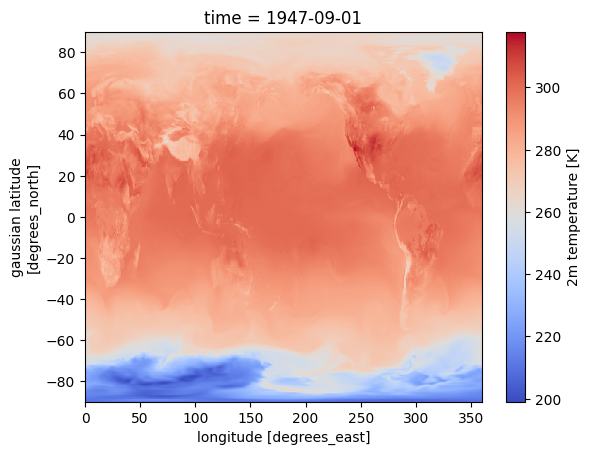

In [ ]:
# a quick one time slice glance of the data
ds = dict_datasets['tmp2m-hgt-an-gauss.tmp2m-hgt-an-gauss']
ds['tmp2m-hgt-an-gauss'].isel(time=0).plot(cmap='coolwarm')

In [25]:
%%time 
# a quick calculation of global mean surface temperature hourly time series
da_tmp2m = ds['tmp2m-hgt-an-gauss'].sel(time=slice('2025-01-01','2025-09-25')).mean(dim=['lat','lon']).compute()


CPU times: user 2min 22s, sys: 2.21 s, total: 2min 25s
Wall time: 2min


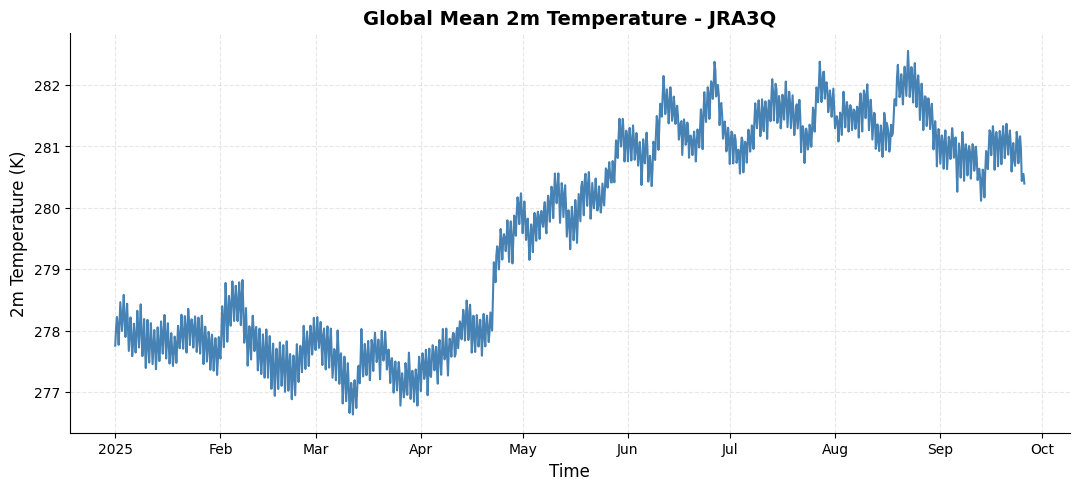

In [ ]:
import matplotlib.pyplot as plt

# Create a customized time series plot
fig = plt.figure(figsize=(10, 4))
ax = fig.add_axes([0, 0, 1, 1])

# plot time series
da_tmp2m.plot(ax=ax, color='steelblue', linewidth=1.5)

# Customize the plot
ax.set_title('Global Mean 2m Temperature - JRA3Q', fontsize=14, fontweight='bold')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('2m Temperature (K)', fontsize=12)
ax.grid(True, alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
